# Drug-likeness of recombined ligands vs. PKIDB ligands

In order to assess the drug-likeness of our > 15M recombined ligands,

* calculate the drug-likeness of our recombined ligands and 
* compare it to the drug-likeness of ligands from the PKIDB, which are approved and investigorial kinase inhibitors and therefore give an idea on how an ideal kinase inhibitor's drug-likeness looks like.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem, PandasTools
from rdkit.Chem.Draw import IPythonConsole

import kinase_focused_fragment_library as kffl
import klifs_utils as klifs

RDKit WARNING: [11:10:16] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
url = 'https://raw.githubusercontent.com/dominiquesydow/pkidb_klifs/master/results/pkidb_20200218.csv'

In [4]:
PROJECT_PATH = Path('../../../..') / 'KinaseFocusedFragmentLibraryData'

combinatorial_path = PROJECT_PATH / 'CombinatorialLibrary' / 'combinatorial_library.pickle'
cominatorial_unique_index_path = PROJECT_PATH / 'CombinatorialLibrary' / 'unique_molecule_ids.txt'
fragment_path = PROJECT_PATH / 'FragmentLibrary/'

## Load ligand data

### PKIDB ligands

PKIDB ligands: approved and investigorial kinase inhibitors

In [5]:
pkidb_ligands = pd.read_csv(url, index_col=0)
print(f'PKIDB ligands: {pkidb_ligands.shape[0]}')

PKIDB ligands: 218


### Original ligands

In [6]:
# Load fragment library
fragment_library = kffl.analysis.fragment_analysis.util.read_fragment_library(fragment_path, remove_dummy=True, reduced='_reduced_0.6')
del fragment_library['X']

# Get deduplicated kinase-structure pairs
kinase_structure_pairs = kffl.analysis.fragment_analysis.util.get_deduplicated_original_complexes(fragment_library)
kinase_structure_pairs['species'] = 'HUMAN'

kinase_structure_pairs.head(2)

Fragments: 801
Deduplicated kinase-structure pairs from which fragments originate: 694


,kinase,klifs_code,species
0,CHK1,4qyg_chainA,HUMAN
1,PIM1,5mzl_altA_chainA,HUMAN


In [7]:
# Get ligands
original_ligands = []

for index, row in kinase_structure_pairs.iterrows():
    ligand_mol2_path = PROJECT_PATH / 'KLIFS_download' / row.species / row.kinase / row.klifs_code / 'ligand.mol2'
    ligand = Chem.MolFromMol2File(str(ligand_mol2_path))
    original_ligands.append(ligand)

### Recombined ligands

In [8]:
combinatorial_unique_index_path = PROJECT_PATH / 'CombinatorialLibrary' / 'unique_molecule_ids.txt'

In [9]:
# Takes up to a minute to load (about 16M entries)
combinatorial_unique_index = np.genfromtxt(combinatorial_unique_index_path, dtype=int, delimiter='/n')

## Get drug-likeness

### PKIDB ligands

In [10]:
drug_likeness_pkidb = kffl.analysis.ligand_analysis.util.drug_likeness_from_smiles(pkidb_ligands.Canonical_Smiles)

Number of molecules: 218


### Original ligands

In [11]:
drug_likeness_klifs = kffl.analysis.ligand_analysis.util.drug_likeness_from_mols(original_ligands)

Number of molecules: 694


### Recombined ligands

In [12]:
drug_likeness_recomb = kffl.analysis.ligand_analysis.util.drug_likeness_from_pickle(combinatorial_path, combinatorial_unique_index)
drug_likeness_recomb

2020-04-06 11:11:20.776021: start
2020-04-06 11:11:20.783661: step 0
2020-04-06 11:11:34.940171: step 1000000
2020-04-06 11:11:47.313670: step 2000000
2020-04-06 11:11:59.914804: step 3000000
2020-04-06 11:12:12.516401: step 4000000
2020-04-06 11:12:24.543230: step 5000000
2020-04-06 11:12:36.641959: step 6000000
2020-04-06 11:12:49.204100: step 7000000
2020-04-06 11:13:01.937562: step 8000000
2020-04-06 11:13:15.189996: step 9000000
2020-04-06 11:13:28.391428: step 10000000
2020-04-06 11:13:41.394236: step 11000000
2020-04-06 11:13:53.830738: step 12000000
2020-04-06 11:14:06.071739: step 13000000
2020-04-06 11:14:18.727651: step 14000000
2020-04-06 11:14:30.955119: step 15000000
2020-04-06 11:14:41.581553: end
Number of molecules: 15863732
mw           3901156
hba          8864503
hbd         15145516
logp        10082156
lipinski     6266726
dtype: int64
mw          24.591666
hba         55.879052
hbd         95.472591
logp        63.554755
lipinski    39.503479
dtype: float64


mw          25.0
hba         56.0
hbd         95.0
logp        64.0
lipinski    40.0
dtype: float64

## Plot drug likeness

In [13]:
drug_likeness_pkidb

mw           70.0
logp         74.0
hbd         100.0
hba          99.0
lipinski     85.0
dtype: float64

In [14]:
# Collect data in one DataFrame
bar_data = pd.DataFrame(
    {
        'Recombined ligands': drug_likeness_recomb, 
        'Original ligands (KLIFS)': drug_likeness_klifs, 
        'PKIDB ligands': drug_likeness_pkidb
    }
)
bar_data = bar_data.astype('int32')
bar_data

,Recombined ligands,Original ligands (KLIFS),PKIDB ligands
hba,56,99,99
hbd,95,98,100
lipinski,40,94,85
logp,64,90,74
mw,25,82,70


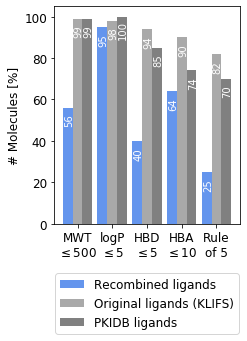

In [67]:
# Plot data
ax = bar_data.plot(
    kind='bar',
    width=0.85,
    rot=0,
    figsize=(3.33, 4),
    color=['cornflowerblue', 'darkgrey', 'grey']
)

# Edit labels for y axis and x/y ticks
plt.ylabel('# Molecules [%]', fontsize=12)
plt.xticks(range(5), ['MWT\n'+r'$\leq 500$', 'logP\n'+r'$\leq 5$', 'HBD\n'+r'$\leq 5$', 'HBA\n'+r'$\leq 10$', 'Rule\nof 5'], fontsize=12)
plt.yticks(fontsize=12)
#plt.legend(fontsize=12, loc='upper left')
legend = plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5,-.2),
           fontsize=12
          )

# Add percentages to bars
bars = ax.patches
bar_labels = bar_data.transpose().values.flatten()
for bar, label in zip(bars, bar_labels):
    
    plt.text(
        bar.get_x() + bar.get_width() / 1.6, 
        bar.get_height() - 6,
        label, 
        ha='center', 
        va='center', 
        fontsize=10,
        color='white',
        rotation=90
    )

In [68]:
ax.get_figure().savefig(
    PROJECT_PATH / 'Media' / 'ra_lipinski.pdf',
    bbox_extra_artists=(legend,),
    bbox_inches='tight'
)